# Word2Vec (Negative Sampling)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
np.__version__, torch.__version__

('2.3.4', '2.9.1+cu130')

In [3]:
import matplotlib
matplotlib.__version__

'3.10.7'

## 1. Load data

### Dataset: Reuters-21578 (NLTK)

We train on the **Reuters-21578** newswire corpus distributed with the **NLTK** library (`nltk.corpus.reuters`). This provides real-world news text categorized by topic.

**Source/Credit:** Reuters-21578 corpus as packaged by NLTK.

In [4]:
# Load a real-world corpus: Reuters-21578 (news) from NLTK

import nltk
from nltk.corpus import reuters
from collections import Counter

# Download once (safe to call repeatedly)
nltk.download('reuters')

def preprocess_sentence(tokens):
    """Lowercase and keep alphabetic tokens only."""
    return [t.lower() for t in tokens if t.isalpha()]

# Reuters sentences are already tokenized by NLTK
raw_sents = reuters.sents()
corpus = [preprocess_sentence(s) for s in raw_sents]
corpus = [s for s in corpus if len(s) >= 3]

# (Optional) limit the number of sentences for faster training during development
MAX_SENTS = 5000
corpus = corpus[:MAX_SENTS]

len(corpus), corpus[0][:20]


[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\Windows\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


(5000,
 ['asian',
  'exporters',
  'fear',
  'damage',
  'from',
  'u',
  's',
  'japan',
  'rift',
  'mounting',
  'trade',
  'friction',
  'between',
  'the',
  'u',
  's',
  'and',
  'japan',
  'has',
  'raised'])

In [5]:
# Preview a few tokenized sentences
corpus[:3]


[['asian',
  'exporters',
  'fear',
  'damage',
  'from',
  'u',
  's',
  'japan',
  'rift',
  'mounting',
  'trade',
  'friction',
  'between',
  'the',
  'u',
  's',
  'and',
  'japan',
  'has',
  'raised',
  'fears',
  'among',
  'many',
  'of',
  'asia',
  's',
  'exporting',
  'nations',
  'that',
  'the',
  'row',
  'could',
  'inflict',
  'far',
  'reaching',
  'economic',
  'damage',
  'businessmen',
  'and',
  'officials',
  'said'],
 ['they',
  'told',
  'reuter',
  'correspondents',
  'in',
  'asian',
  'capitals',
  'a',
  'u',
  's',
  'move',
  'against',
  'japan',
  'might',
  'boost',
  'protectionist',
  'sentiment',
  'in',
  'the',
  'u',
  's',
  'and',
  'lead',
  'to',
  'curbs',
  'on',
  'american',
  'imports',
  'of',
  'their',
  'products'],
 ['but',
  'some',
  'exporters',
  'said',
  'that',
  'while',
  'the',
  'conflict',
  'would',
  'hurt',
  'them',
  'in',
  'the',
  'long',
  'run',
  'in',
  'the',
  'short',
  'term',
  'tokyo',
  's',
  'loss'

In [6]:
# Build vocabulary (frequency-based) and add <UNK>

VOCAB_SIZE = 10000  # including <UNK>

counts = Counter(token for sent in corpus for token in sent)
most_common = counts.most_common(VOCAB_SIZE - 1)
vocabs = [w for w, _ in most_common]
vocabs.append('<UNK>')

word2index = {w: i for i, w in enumerate(vocabs)}
index2word = {i: w for w, i in word2index.items()}

len(vocabs), vocabs[:10]


(8651, ['the', 'of', 'to', 'in', 'and', 'said', 'a', 'mln', 's', 'vs'])

In [7]:
# Sanity checks
word2index.get('oil', word2index['<UNK>']), index2word[word2index.get('oil', word2index['<UNK>'])]


(76, 'oil')

In [8]:
# Example of unknown token handling
word2index.get('this_token_is_not_in_vocab', word2index['<UNK>'])


8650

In [9]:
# Vocabulary size
len(word2index)


8651

## 2. Prepare train data

In [10]:
# Create (center, context) pairs for Skip-gram with a dynamic window size

def random_batch(batch_size, corpus, window_size=2):
    """
    window_size: number of words to the left/right to consider (default=2).
    For each center token, we create pairs with all context tokens within +/- window_size.
    """

    skipgrams = []

    for sent in corpus:
        for i in range(len(sent)):
            center_word = sent[i]
            center = word2index.get(center_word, word2index['<UNK>'])

            # collect context within the window
            for offset in range(1, window_size + 1):
                left_i = i - offset
                right_i = i + offset

                if left_i >= 0:
                    left_word = sent[left_i]
                    outside = word2index.get(left_word, word2index['<UNK>'])
                    skipgrams.append([center, outside])

                if right_i < len(sent):
                    right_word = sent[right_i]
                    outside = word2index.get(right_word, word2index['<UNK>'])
                    skipgrams.append([center, outside])

    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)

    inputs, labels = [], []
    for index in random_index:
        inputs.append([skipgrams[index][0]])
        labels.append([skipgrams[index][1]])

    return np.array(inputs), np.array(labels)

# default window_size=2
x, y = random_batch(2, corpus)


In [11]:
x.shape  #batch_size, 1

(2, 1)

In [12]:
x

array([[27],
       [21]])

In [13]:
y.shape  #batch_size 1

(2, 1)

## 3. Negative Sampling

### Unigram distribution

$$P(w)=U(w)^{3/4}/Z$$

In [14]:
z = 0.001

In [15]:
# Count token frequencies for unigram distribution
from collections import Counter

# word_count based on the training corpus (already preprocessed)
word_count = Counter(token for sent in corpus for token in sent)

# Ensure <UNK> exists (it may have zero count)
word_count['<UNK>'] = word_count.get('<UNK>', 0)

# total number of tokens
num_total_words = sum(word_count.values())

list(word_count.items())[:10], num_total_words


([('asian', 2),
  ('exporters', 35),
  ('fear', 4),
  ('damage', 17),
  ('from', 703),
  ('u', 543),
  ('s', 1441),
  ('japan', 231),
  ('rift', 1),
  ('mounting', 5)],
 119137)

In [16]:
vocabs

['the',
 'of',
 'to',
 'in',
 'and',
 'said',
 'a',
 'mln',
 's',
 'vs',
 'for',
 'dlrs',
 'it',
 'pct',
 'on',
 'lt',
 'cts',
 'at',
 'from',
 'that',
 'its',
 'by',
 'is',
 'net',
 'year',
 'be',
 'billion',
 'was',
 'u',
 'with',
 'has',
 'will',
 'as',
 'he',
 'an',
 'company',
 'not',
 'would',
 'nil',
 'shr',
 'last',
 'tonnes',
 'loss',
 'inc',
 'are',
 'were',
 'but',
 'corp',
 'bank',
 'this',
 'which',
 'they',
 'share',
 'qtr',
 'trade',
 'one',
 'have',
 'shares',
 'april',
 'or',
 'market',
 'first',
 'quarter',
 'had',
 'about',
 'japan',
 'new',
 'dollar',
 'may',
 'also',
 'price',
 'profit',
 'sales',
 'two',
 'stock',
 'exports',
 'oil',
 'per',
 'been',
 'week',
 'more',
 'up',
 'than',
 'after',
 'note',
 'rate',
 'co',
 'total',
 'revs',
 'march',
 'other',
 'imports',
 'end',
 'month',
 'rates',
 'some',
 'group',
 'we',
 'production',
 'stocks',
 'stg',
 'government',
 'prices',
 'agreement',
 'interest',
 'offer',
 'exchange',
 'wheat',
 'yen',
 'today',
 'no',


$$P(w)=U(w)^{3/4}/Z$$

In [17]:
unigram_table = []

for v in vocabs:
    # If v is not in word_count (e.g., <UNK>), treat its count as 0
    uw = word_count.get(v, 0) / num_total_words
    uw_alpha = int((uw ** 0.75) / z)
    if uw_alpha > 0:
        unigram_table.extend([v] * uw_alpha)

# Inspect the (approximate) sampling distribution
from collections import Counter
Counter(unigram_table).most_common(10), len(unigram_table)


([('the', 106),
  ('of', 67),
  ('to', 64),
  ('in', 56),
  ('and', 51),
  ('said', 50),
  ('a', 48),
  ('mln', 43),
  ('s', 36),
  ('vs', 34)],
 3680)

## 4. Model

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [18]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index['<UNK>'], seq))
    return torch.LongTensor(idxs)

In [19]:
import random

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.shape[0]
    neg_samples = []
    for i in range(batch_size):  #(1, k)
        target_index = targets[i].item()
        nsample      = []
        while (len(nsample) < k):
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))
        
    return torch.cat(neg_samples) #batch_size, k

In [20]:
batch_size = 2
x, y = random_batch(batch_size, corpus)
x_tensor = torch.LongTensor(x)
y_tensor = torch.LongTensor(y)

In [21]:
k = 5
neg_samples = negative_sampling(y_tensor, unigram_table, k)

In [22]:
y_tensor[1]

tensor([1])

In [23]:
neg_samples[1]

tensor([  40, 1129, 1002,  139,  636])

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [24]:
class SkipgramNeg(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_center  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside = nn.Embedding(voc_size, emb_size)
        self.logsigmoid        = nn.LogSigmoid()
    
    def forward(self, center, outside, negative):
        #center, outside:  (bs, 1)
        #negative       :  (bs, k)
        
        center_embed   = self.embedding_center(center) #(bs, 1, emb_size)
        outside_embed  = self.embedding_outside(outside) #(bs, 1, emb_size)
        negative_embed = self.embedding_outside(negative) #(bs, k, emb_size)
        
        uovc           = outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, 1)
        ukvc           = -negative_embed.bmm(center_embed.transpose(1, 2)).squeeze(2) #(bs, k)
        ukvc_sum       = torch.sum(ukvc, 1).reshape(-1, 1) #(bs, 1)
        
        loss           = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)
        
        return -torch.mean(loss)

In [25]:
#test your model
emb_size = 2
voc_size = len(vocabs)
model = SkipgramNeg(voc_size, emb_size)

In [26]:
loss = model(x_tensor, y_tensor, neg_samples)

In [27]:
loss

tensor(4.2502, grad_fn=<NegBackward0>)

## 5. Training

In [28]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [29]:
num_epochs = 10000

for epoch in range(num_epochs):
    
    #get batch
    input_batch, label_batch = random_batch(batch_size, corpus)
    input_tensor = torch.LongTensor(input_batch)
    label_tensor = torch.LongTensor(label_batch)
    
    #predict
    neg_samples = negative_sampling(label_tensor, unigram_table, k)
    loss = model(input_tensor, label_tensor, neg_samples)
    
    #backprogate
    optimizer.zero_grad()
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print the loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1:6.0f} | Loss: {loss:2.6f}")

Epoch   1000 | Loss: 1.726861
Epoch   2000 | Loss: 1.470783
Epoch   3000 | Loss: 1.108711
Epoch   4000 | Loss: 1.150950
Epoch   5000 | Loss: 2.002989
Epoch   6000 | Loss: 1.583970
Epoch   7000 | Loss: 0.651710
Epoch   8000 | Loss: 2.983079
Epoch   9000 | Loss: 1.684471
Epoch  10000 | Loss: 0.811000


## 6. Plot the embeddings

In [30]:
vocabs

['the',
 'of',
 'to',
 'in',
 'and',
 'said',
 'a',
 'mln',
 's',
 'vs',
 'for',
 'dlrs',
 'it',
 'pct',
 'on',
 'lt',
 'cts',
 'at',
 'from',
 'that',
 'its',
 'by',
 'is',
 'net',
 'year',
 'be',
 'billion',
 'was',
 'u',
 'with',
 'has',
 'will',
 'as',
 'he',
 'an',
 'company',
 'not',
 'would',
 'nil',
 'shr',
 'last',
 'tonnes',
 'loss',
 'inc',
 'are',
 'were',
 'but',
 'corp',
 'bank',
 'this',
 'which',
 'they',
 'share',
 'qtr',
 'trade',
 'one',
 'have',
 'shares',
 'april',
 'or',
 'market',
 'first',
 'quarter',
 'had',
 'about',
 'japan',
 'new',
 'dollar',
 'may',
 'also',
 'price',
 'profit',
 'sales',
 'two',
 'stock',
 'exports',
 'oil',
 'per',
 'been',
 'week',
 'more',
 'up',
 'than',
 'after',
 'note',
 'rate',
 'co',
 'total',
 'revs',
 'march',
 'other',
 'imports',
 'end',
 'month',
 'rates',
 'some',
 'group',
 'we',
 'production',
 'stocks',
 'stg',
 'government',
 'prices',
 'agreement',
 'interest',
 'offer',
 'exchange',
 'wheat',
 'yen',
 'today',
 'no',


In [31]:
banana = torch.LongTensor([word2index['banana']])
banana

tensor([6030])

In [32]:
banana_embed_c = model.embedding_center(banana)
banana_embed_o = model.embedding_outside(banana)
banana_embed   = (banana_embed_c + banana_embed_o) / 2
banana_embed

tensor([[-0.7369,  1.1807]], grad_fn=<DivBackward0>)

In [33]:
banana_embed_o

tensor([[-1.3133,  0.5270]], grad_fn=<EmbeddingBackward0>)

In [34]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
        
    word = torch.LongTensor([word2index[word]])
    
    embed_c = model.embedding_center(word)
    embed_o = model.embedding_outside(word)
    embed   = (embed_c + embed_o) / 2
    
    return embed[0][0].item(), embed[0][1].item()

In [35]:
get_embed('fruit')

(-0.6162848472595215, 0.4205320477485657)

In [36]:
get_embed('cat')

(-0.5439394116401672, -0.004451438784599304)

In [38]:
get_embed('japan')

(-0.21399527788162231, -0.10085099935531616)

In [40]:
get_embed('harry')

(1.0000196695327759, 1.2777879238128662)

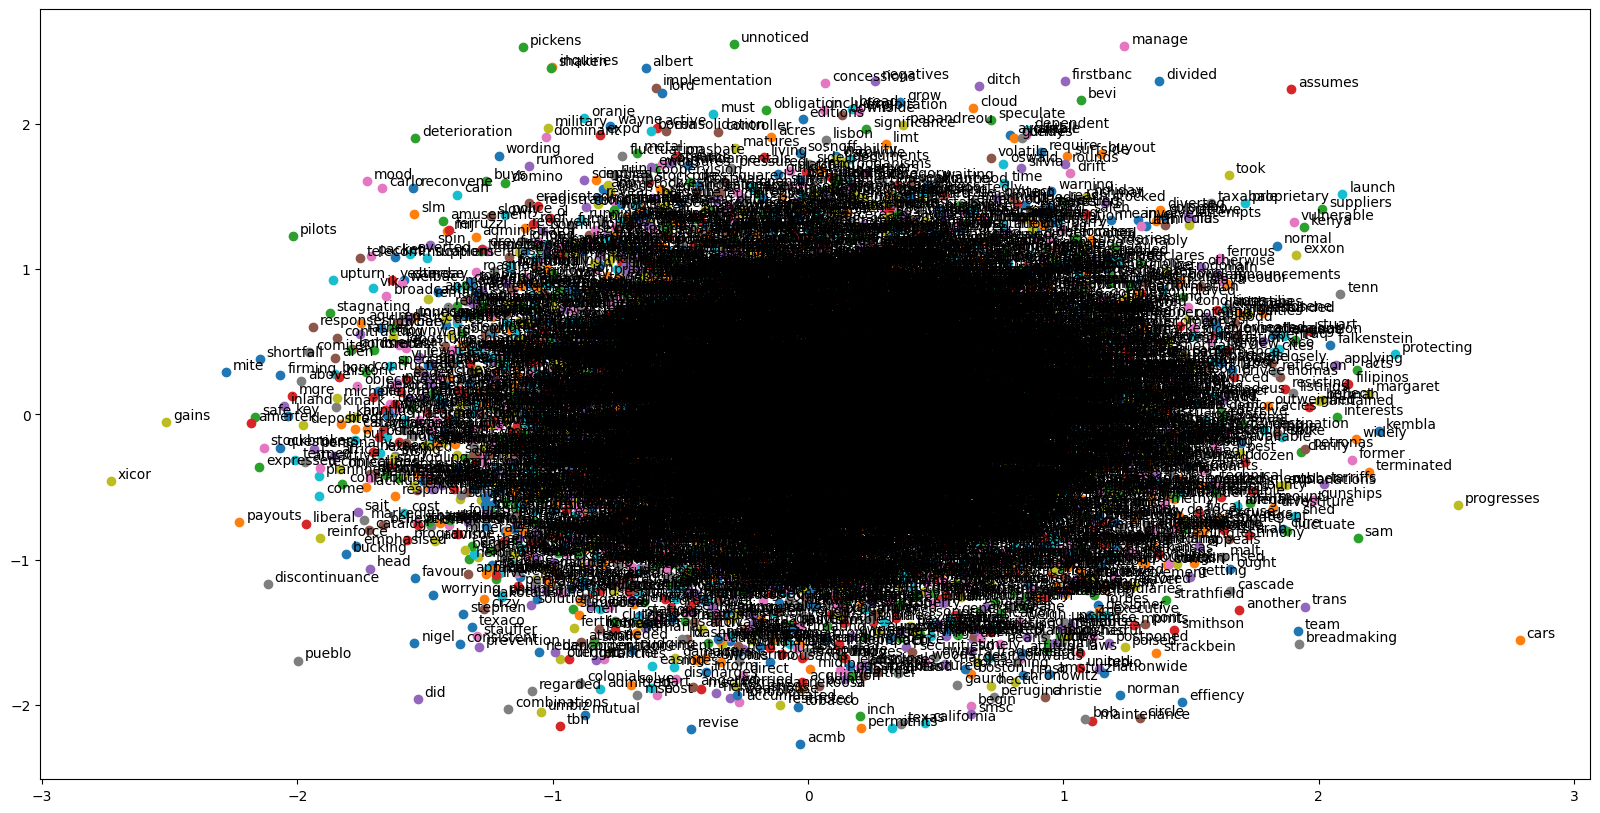

In [42]:
plt.figure(figsize=(20, 10))
for i, word in enumerate(vocabs):
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 7. Cosine similarity

In [43]:
banana = get_embed('banana')
banana

(-0.7368876934051514, 1.1807401180267334)

In [44]:
fruit = get_embed('fruit')
fruit

(-0.6162848472595215, 0.4205320477485657)

In [45]:
cat = get_embed('cat')
cat

(-0.5439394116401672, -0.004451438784599304)

In [46]:
np.array(banana) @ np.array(cat)

np.float64(0.3955662660397614)

In [47]:
#more formally is to divide by its norm
def cosine_similarity(A, B):
    dot_product = np.dot(A, B)
    norm_a = np.linalg.norm(A)
    norm_b = np.linalg.norm(B)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

print(cosine_similarity(np.array(banana), np.array(cat)))
print(cosine_similarity(np.array(banana), np.array(fruit)))

0.5224833728398034
0.9154953586042329
